# 1.SNAP数据集中的facebook-ego数据集

## 1.1获取数据并对数据进行预处理
在指定的数据集网站下载数据集，并存放在G盘

导入数据挖掘以及数据分析的python库包

In [28]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import gzip
import networkx as nx
import pylab
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

facebook = pd.read_csv(
    r"G:\facebook_combined.txt.gz",
    sep=" ",
    names=["start_node", "end_node"],
    header=None,
)

获取属性名称并展示前10行数据

In [17]:
print(type(facebook))
# 打印前10条数据
print(facebook.head(10))


<class 'pandas.core.frame.DataFrame'>
   start_node  end_node
0           0         1
1           0         2
2           0         3
3           0         4
4           0         5
5           0         6
6           0         7
7           0         8
8           0         9
9           0        10


## 1.2 查看该数据集是否有缺失值

In [24]:
print("\nstart_node属性缺失值个数：")
print(facebook['start_node'].isnull().sum())
print("\nend_node属性缺失值个数：")
print(facebook['end_node'].isnull().sum())


start_node属性缺失值个数：
0

end_node属性缺失值个数：
0


可以看到无缺失值，因此不需要做缺失值处理

## 1.3可视化图

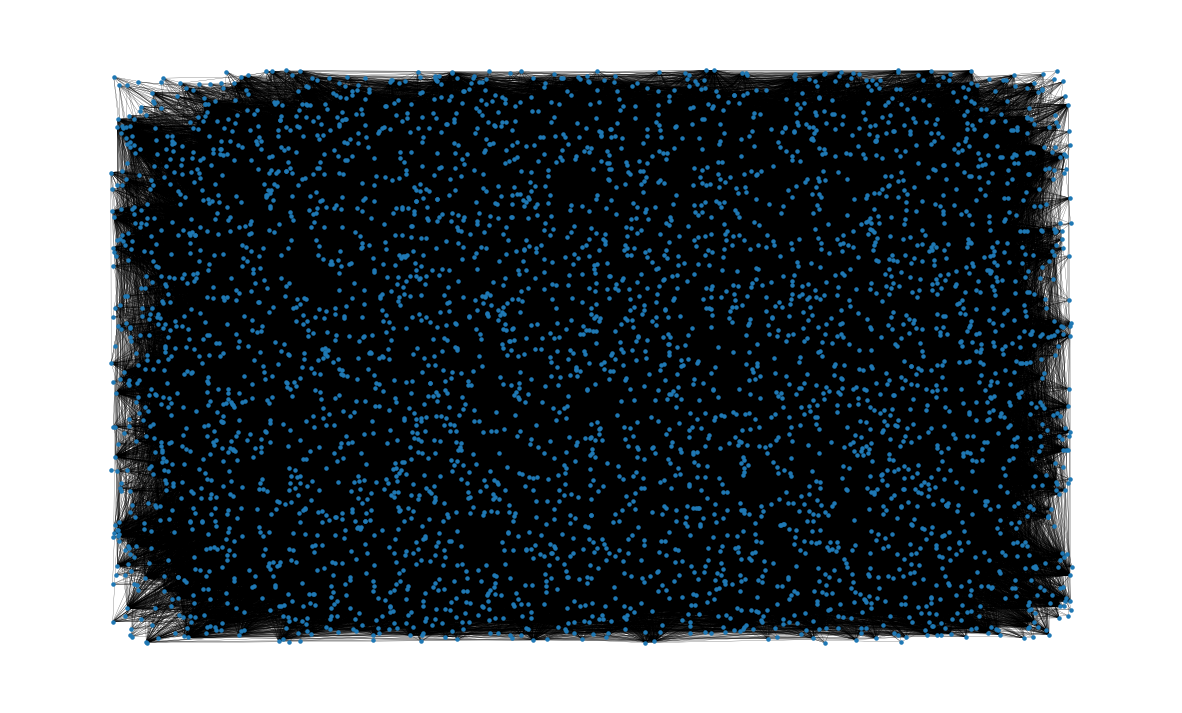

In [30]:
G = nx.from_pandas_edgelist(facebook, "start_node", "end_node")
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")#关闭所有坐标轴线、刻度标记和标签
plot_options = {"node_size": 5, "with_labels": False, "width": 0.15}
nx.draw(G, pos=nx.random_layout(G), ax=ax, **plot_options)
pylab.show()

如图：看不出任何结构，不是没有结构，而是结构没有排列好，因为节点排列有问题，太多边重叠混杂在一起
解决方法：使用spring_layout（）函数重新排列节点，此函数可以根据节点的连接结构计算节点的位置，但是对Facebook数据集，节点太多，计算很复杂，且耗时，设置迭代次数。

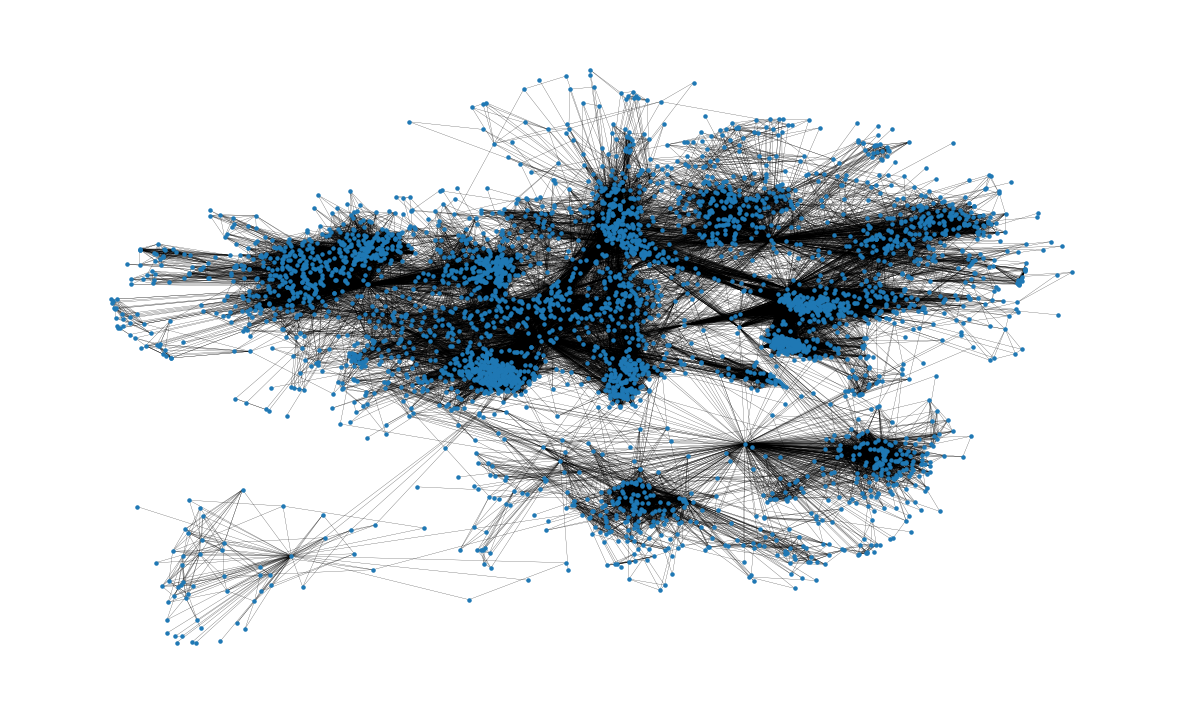

In [31]:
pos = nx.spring_layout(G, iterations=15, seed=2500)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)
pylab.show()


## 1.4 查看图的拓扑属性

查看图中的节点数和边数

In [33]:
#网络中的节点总数：
print(G.number_of_nodes())
#边总数
print(G.number_of_edges())


4039
88234


查看节点的平均度

In [34]:
G.degree()#输出为图的datafram数据，需将其转换为列表
d=list( G.degree())
print(np.mean(d,axis=0))#axis=0，对列求均值

[2019.           43.69101263]


计算节点间的最短路径长度

nx.all_pairs_shortest_path_length返回一个字典的字典，该字典将节点映射到网络中的所有其他节点，其中最里面的映射返回 两个节点之间的最短路径的长度。 换句话说，将返回最短路径 任意两对节点之间的长度和：ushortest_path_lengths[u][v]uv

In [35]:
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))
print(shortest_path_lengths[0][43])  # Length of shortest path between nodes 0 and 42

1


## 1.5 中心度度量

度中心性仅根据每个节点持有的邻居数分配重要性分数。

度中心性越高，该节点的邻居节点（facebook 朋友）就越多。

In [36]:
degree_centrality = nx.centrality.degree_centrality(G)
# nx.centrality.degree_centrality(G)返回值为字典类型，键是节点序号，值为度中心性
#按度的大小降序输出所有的节点
def dict_sort_by_value(dict_input):
    '''
    输入字典，输出按值排序的字典
    '''
    return sorted(dict_input.items(),key=lambda x : x[1], reverse=True)   
print((dict_sort_by_value(degree_centrality))[:8]) #输出前八个中心度最高的节点


[(107, 0.258791480931154), (1684, 0.1961367013372957), (1912, 0.18697374938088163), (3437, 0.13546310054482416), (0, 0.08593363051015354), (2543, 0.07280832095096582), (2347, 0.07206537890044576), (1888, 0.0629024269440317)]


绘制度中心性的分布：

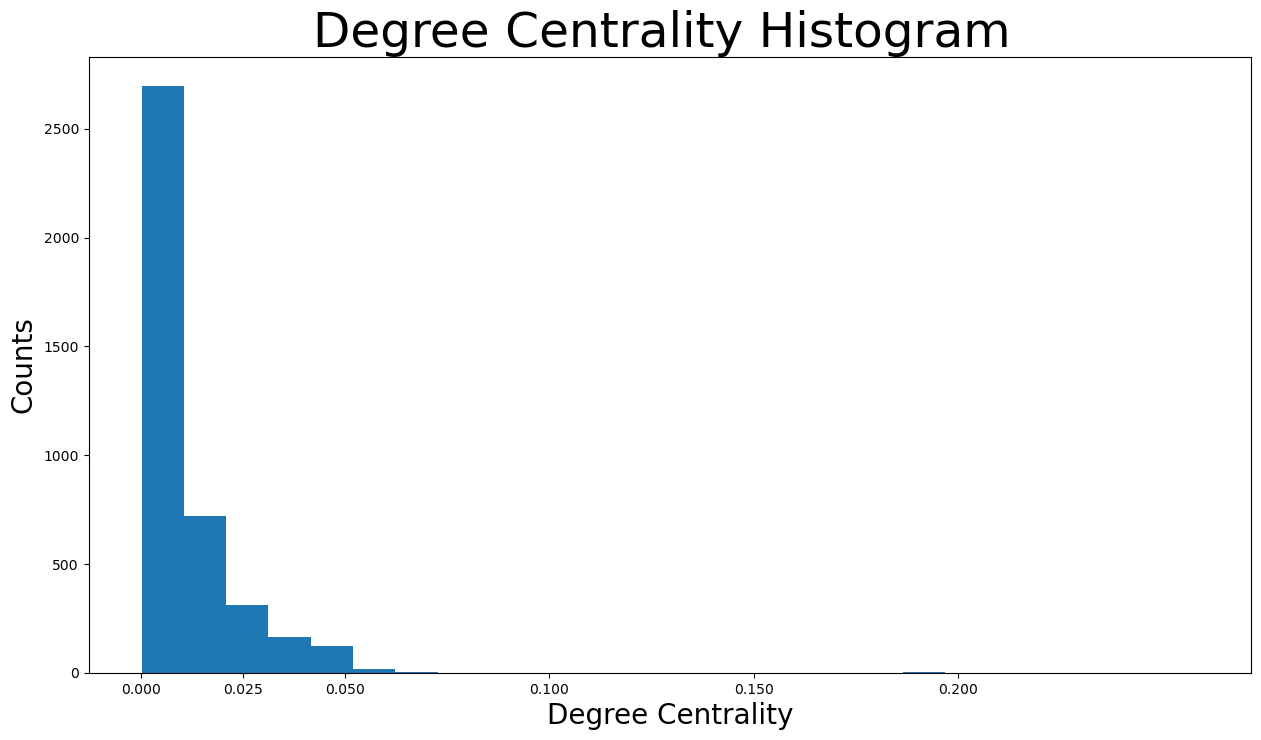

In [37]:
plt.figure(figsize=(15, 8))
plt.hist(degree_centrality.values(), bins=25)#分成25个区间，然后计算每个间隔中有多少值
plt.xticks(ticks=[0, 0.025, 0.05, 0.1, 0.15, 0.2])  # 设置横坐标的标度
plt.title("Degree Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})
plt.show()

可以看出，绝大多数Facebook用户的度中心性小于0.05。大多数人的比0.0125还低 .许多节点具有极低度的中心性，因为它们在这个网络中不连接（不认识）。

修改画图，调整节点的大小，度中心大的节点画大一些，突出

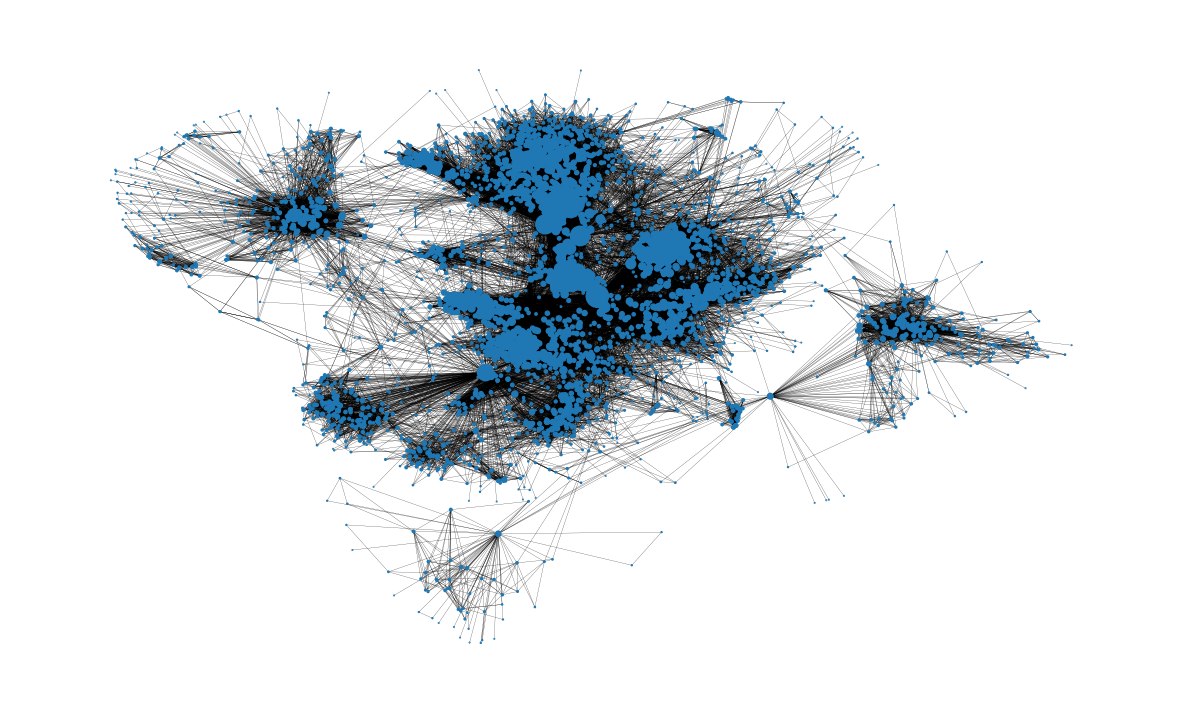

In [39]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
node_size = [ v * 1000 for v in degree_centrality.values()]  
# set up nodes size for a nice graph representation
#nx.draw_networkx(G, node_size=node_size,pos=pos, ax=ax, **plot_options)
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
pylab.show()

## 1.6 查看网络的社区

1：半同步标签传播方法对群落进行检测

44


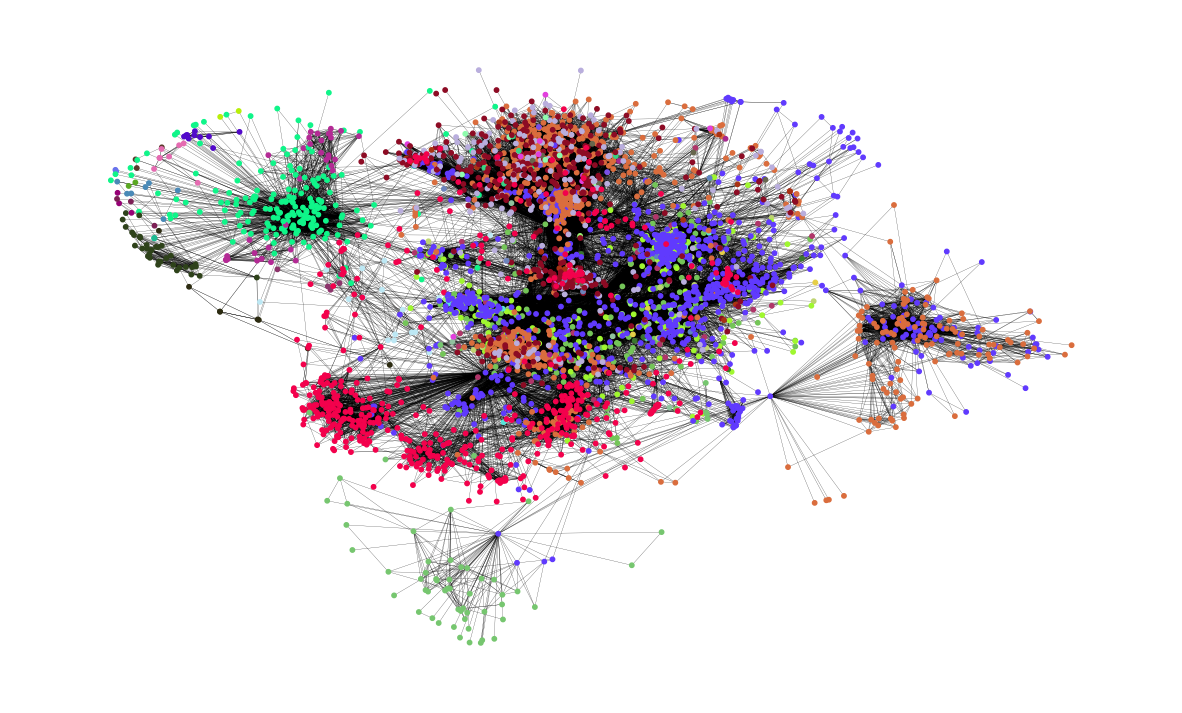

In [40]:
colors = ["" for x in range(G.number_of_nodes())]  # initialize colors list
counter = 0
for com in nx.community.label_propagation_communities(G):
    color = "#%06X" % randint(0, 0xFFFFFF)  # creates random RGB color
    counter += 1
    for node in list(
        com
    ):  # fill colors list with the particular color for the community nodes
        colors[node] = color
print(counter)
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors
)
pylab.show()

使用这种方法发现44个社区

2:异步流体群落算法

假设有8个社区，画出其分布图

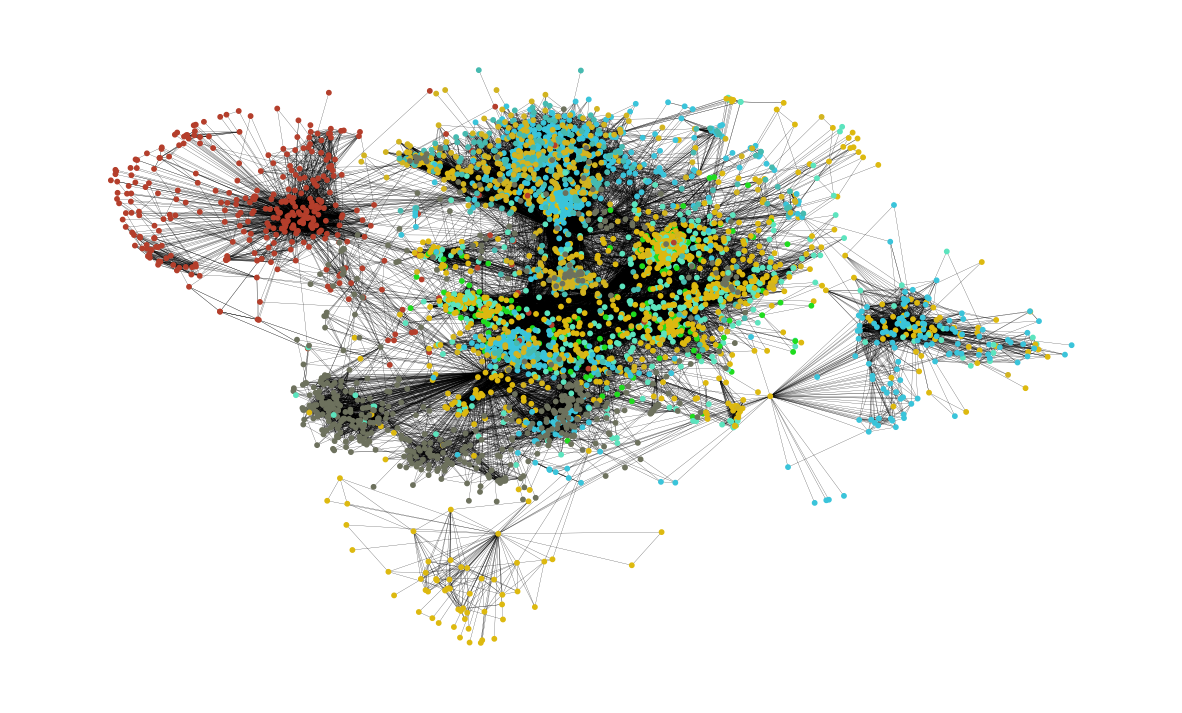

In [43]:
colors = ["" for x in range(G.number_of_nodes())]
for com in nx.community.asyn_fluidc(G, 8, seed=0):
    color = "#%06X" % randint(0, 0xFFFFFF)  # creates random RGB color
    for node in list(com):
        colors[node] = color
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors
)
pylab.show()

## 1.7频繁集挖掘

设置最小支持度为0.05，如果两个节点间有一条边，则二者互为好友，将图转化为一个字典形式的保存格式，如果一个人是另一个人的好友，则这个人的id会在另外一个人的id所对应的字典中

In [44]:
transactions = facebook.values.tolist()  # 将DataFrame转换为Python列表
big_list = [[] for _ in range(4039)]

for i in transactions:
    big_list[i[0]].append(i[1])
    big_list[i[1]].append(i[0])
te = TransactionEncoder()
te_ary = te.fit(big_list).transform(big_list)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df, min_support=0.05, use_colnames=True)  # min_support是支持度阈值
print(frequent_itemsets)

     support            itemsets
0   0.085912                 (0)
1   0.258727               (107)
2   0.056697               (348)
3   0.057192               (483)
4   0.050755              (1086)
..       ...                 ...
68  0.058430        (2347, 2543)
69  0.052241   (1800, 107, 1888)
70  0.052241  (1912, 2266, 2142)
71  0.050260  (1912, 2266, 2206)
72  0.058183  (1912, 2347, 2543)

[73 rows x 2 columns]


这里输出的频繁项集代表的含义是有那些人或者是哪几个人经常出现在其他用户的好友列表中

绘制该频繁项集的支持度分布

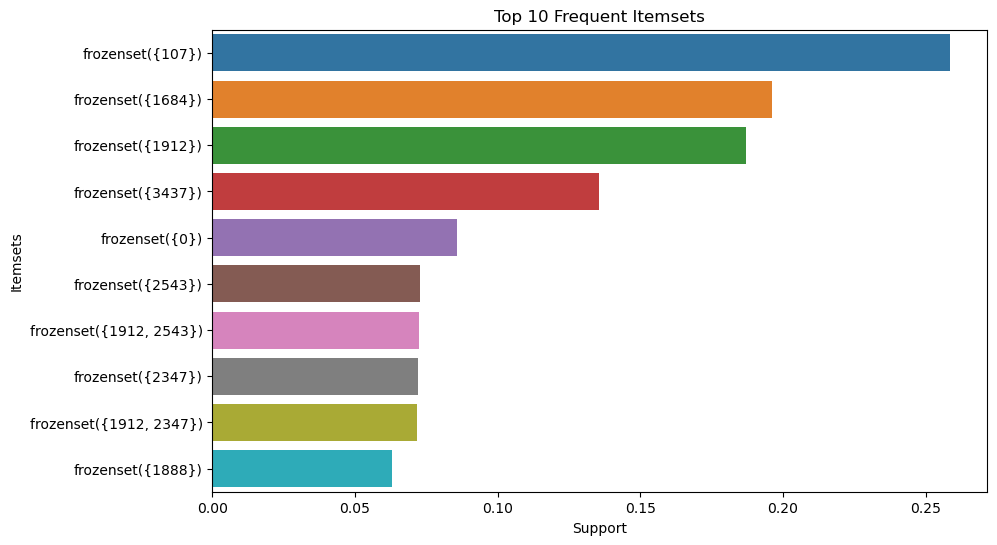

In [48]:
import warnings

# 忽略所有警告
warnings.filterwarnings("ignore")
import seaborn as sns
# 4. 可视化展示
# 绘制频繁项集的支持度分布
plt.figure(figsize=(10, 6))
sns.barplot(x='support', y='itemsets', data=frequent_itemsets.nlargest(10, 'support'))
plt.title('Top 10 Frequent Itemsets')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.show()

## 1.8生成关联规则

这里面的关联规则我称它为“名人关注规则”，因为关联规则中出现的节点应该都是度比较大的，大部分应该都是名人好友较多，而这个规则可以得到当一位用户关注某一位名人时，他有很大可能会关注另外一名名人，就是可能这两个名人风格比较相近，因此用户关注一个大部分时候也会关注另外一个

In [66]:
# 生成关联规则
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.9955)

print(rules[['antecedents', 'consequents', 'support', 'confidence']])

     antecedents consequents   support  confidence
0         (1352)       (107)  0.057688    0.995726
1         (1663)       (107)  0.057935    0.995745
2         (1730)       (107)  0.055707    0.995575
3         (1800)       (107)  0.060411    0.995918
4         (1888)       (107)  0.062639    0.996063
5         (1941)      (1912)  0.054964    0.995516
6         (1985)      (1912)  0.055212    0.995536
7         (2266)      (1912)  0.057688    0.995726
8         (2347)      (1912)  0.071800    0.996564
9         (2543)      (1912)  0.072543    0.996599
10  (2347, 2543)      (1912)  0.058183    0.995763


对关联规则进行可视化展示
绘制其置信度与支持度的散点图 

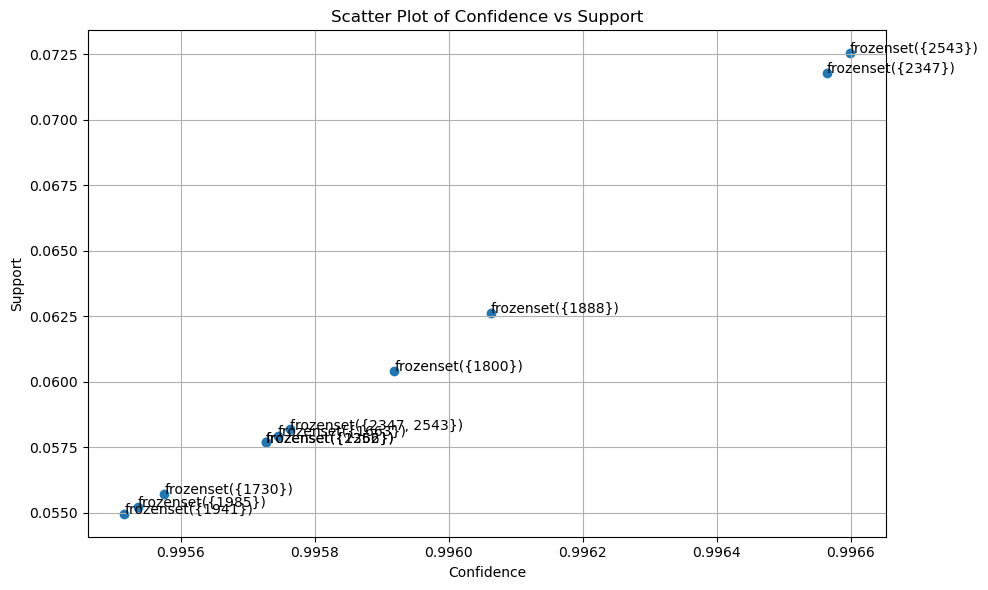

In [67]:
# 4. 可视化展示
# 关联规则可视化：置信度与支持度的散点图  
plt.figure(figsize=(10, 6))  
plt.scatter(rules['confidence'], rules['support'])  
plt.xlabel('Confidence')  
plt.ylabel('Support')  
plt.title('Scatter Plot of Confidence vs Support')  
for i, txt in enumerate(rules['antecedents']):  
    plt.annotate(txt, (rules['confidence'][i], rules['support'][i]))  
plt.grid(True)  
plt.tight_layout()  
plt.show()

# 2.Microsoft 资讯推荐数据集

2.1 数据获取与预处理

数据获取使用的是官网中给出的download函数来进行下载的，将其下载到了一个暂时文件夹中

In [70]:
import os
import tempfile
import shutil
import urllib
import zipfile
import pandas as pd
import urllib.request

temp_dir = os.path.join(tempfile.gettempdir(), 'mind')
os.makedirs(temp_dir, exist_ok=True)

base_url = 'https://mind201910small.blob.core.windows.net/release'
training_small_url = f'{base_url}/MINDsmall_train.zip'
validation_small_url = f'{base_url}/MINDsmall_dev.zip'
training_large_url = f'{base_url}/MINDlarge_train.zip'
validation_large_url = f'{base_url}/MINDlarge_dev.zip'
def download_url(url,
                 destination_filename=None,
                 progress_updater=None,
                 force_download=False,
                 verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('Bypassing download of already-downloaded file {}'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('Downloading file {} to {}'.format(os.path.basename(url),
                                                 destination_filename),
              end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)
    assert (os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename
# For demonstration purpose, we will use small version validation set only.
# This file is about 30MB.
zip_path = download_url(validation_small_url, verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)

behaviors_path = os.path.join(temp_dir, 'behaviors.tsv')
pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])
news_path = os.path.join(temp_dir, 'news.tsv')
pd.read_table(news_path,
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])

entity_embedding_path = os.path.join(temp_dir, 'entity_embedding.vec')
entity_embedding = pd.read_table(entity_embedding_path, header=None)
entity_embedding['vector'] = entity_embedding.iloc[:, 1:101].values.tolist()
entity_embedding = entity_embedding[[0,
                                     'vector']].rename(columns={0: "entity"})
print(entity_embedding)
relation_embedding_path = os.path.join(temp_dir, 'relation_embedding.vec')
relation_embedding = pd.read_table(relation_embedding_path, header=None)
relation_embedding['vector'] = relation_embedding.iloc[:,
                                                       1:101].values.tolist()
relation_embedding = relation_embedding[[0, 'vector'
                                         ]].rename(columns={0: "relation"})
print(relation_embedding)

Bypassing download of already-downloaded file MINDsmall_dev.zip
          entity                                             vector
0         Q34433  [0.017808, -0.073256, 0.102521, -0.059926, -0....
1            Q41  [-0.063388, -0.181451, 0.057501, -0.091254, -0...
2         Q56037  [0.02155, -0.044888, -0.027872, -0.128843, 0.0...
3          Q1860  [0.060958, 0.069934, 0.015832, 0.079471, -0.02...
4         Q39631  [-0.093106, -0.052002, 0.020556, -0.020801, 0....
...          ...                                                ...
22888    Q278846  [0.042413, 0.021957, 0.072414, -0.068437, 0.02...
22889  Q54621949  [-0.018299, -0.048378, -0.021645, -0.079743, 0...
22890  Q42225228  [-0.051346, -0.028947, -0.07587, 0.017512, -0....
22891  Q54862508  [-0.052323, -0.078029, -0.060925, -0.052536, 0...
22892  Q42301562  [-0.00519, -0.047871, 0.009753, -0.0215, -4.9e...

[22893 rows x 2 columns]
     relation                                             vector
0         P31  [-0.073467, -0

## 2.2 对数据集进行读取

In [77]:
import os
import tempfile
import shutil
import urllib
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# 数据路径
temporary_directory = "C:\\Users\\86155\\AppData\\Local\\Temp\\mind"
behaviors_data_path = os.path.join(temporary_directory, 'behaviors.tsv')
news_data_path = os.path.join(temporary_directory, 'news.tsv')

# 读取数据集
user_behaviors = pd.read_csv(
    behaviors_data_path,
    sep='\t',
    header=None,
    names=['ImpressionID', 'UserID', 'Time', 'History', 'Impressions']
)
news_articles = pd.read_csv(
    news_data_path,
    sep='\t',
    header=None,
    names=[
        'ArticleID', 'Category', 'Subcategory', 'Title', 'Abstract', 'URL',
        'TitleEntities', 'AbstractEntities'
    ]
)

# 数据预处理
user_behaviors['Time'] = pd.to_datetime(user_behaviors['Time'])
user_behaviors['History'] = user_behaviors['History'].apply(lambda x: x.split(' ') if isinstance(x, str) else [])
user_behaviors['Impressions'] = user_behaviors['Impressions'].apply(lambda x: x.split(' ') if isinstance(x, str) else [])

# 合并历史浏览和印象数据
transaction_data = user_behaviors['History'] + user_behaviors['Impressions']

## 2.3处理数据对频繁项集进行挖掘分析，并进行支持度可视化

    support    itemsets
0  0.110961  (N11390-0)
1  0.441328  (N11930-0)
2  0.136893  (N12320-0)
3  0.182797  (N12446-0)
4  0.286308  (N13408-0)


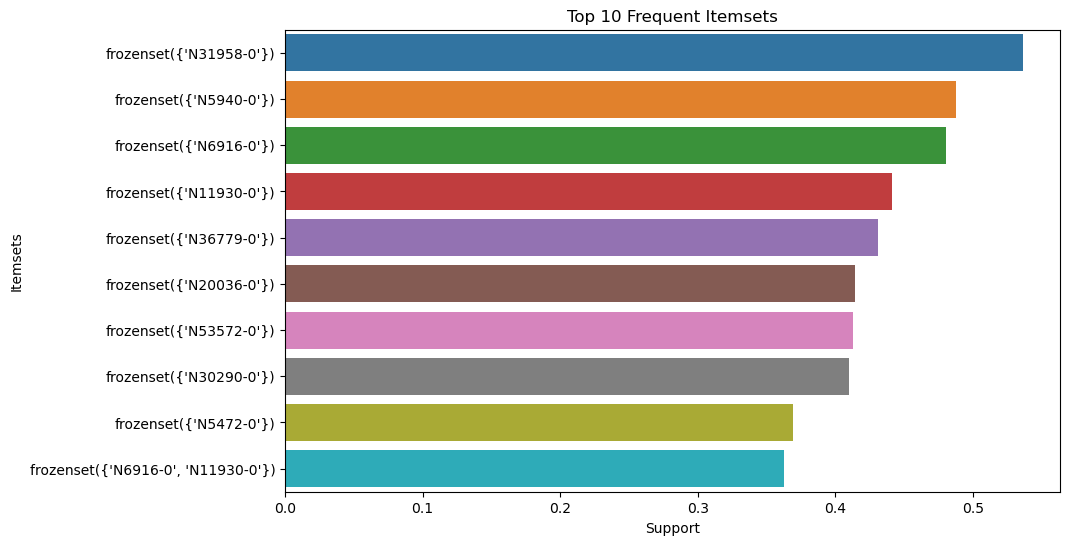

In [78]:
# 独热编码
transaction_encoder = TransactionEncoder()
transaction_matrix = transaction_encoder.fit(transaction_data).transform(transaction_data)
transaction_df = pd.DataFrame(transaction_matrix, columns=transaction_encoder.columns_)

# 频繁项集挖掘
frequent_items = apriori(transaction_df, min_support=0.1, use_colnames=True, low_memory=True)

# 分析频繁项集
print(frequent_items.head())

# 可视化支持度
plt.figure(figsize=(10, 6))
sns.barplot(data=frequent_items.nlargest(10, 'support'), x='support', y='itemsets')
plt.title('Top 10 Frequent Itemsets')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.show()


## 2.4对关联规则进行挖掘并进行可视化

                                    AntecedentsTitle  \
0  [Police find 26 children behind false wall at ...   
1  [The Coolest Way to See NYC Is in a Vintage Ca...   
2  [Homeless woman living in SUV with dogs moves ...   
3  [After Saugus High School shooting, prayer uni...   
4  [Stephanie Parze's Car Is at Home. So Is Her P...   

                                    ConsequentsTitle  confidence      lift  
0  [66 Cool Tech Gifts Anyone Would Be Thrilled t...    0.914870  2.595485  
1  [The most talked about movie moments of the 20...    0.889654  2.015859  
2  [The most talked about movie moments of the 20...    0.836375  1.895133  
3  [The most talked about movie moments of the 20...    0.801721  1.816611  
4  [The most talked about movie moments of the 20...    0.804937  1.823899  


ValueError: number of labels (1) does not match number of bars (10).

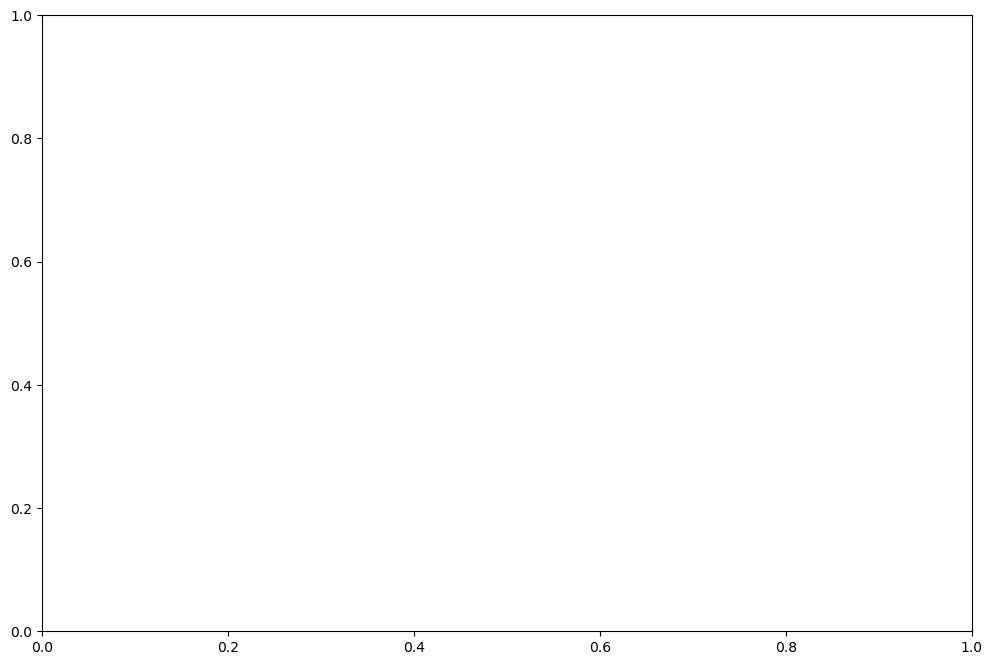

In [80]:
# 关联规则挖掘
association_rules_df = association_rules(frequent_items, metric='confidence', min_threshold=0.7)

# 映射规则中的ID到新闻标题
article_id_to_title = dict(zip(news_articles['ArticleID'], news_articles['Title']))

association_rules_df['AntecedentsTitle'] = association_rules_df['antecedents']\
    .apply(lambda antecedent: [article_id_to_title[item.split("-")[0]] for item in antecedent])
association_rules_df['ConsequentsTitle'] = association_rules_df['consequents']\
    .apply(lambda consequent: [article_id_to_title[item.split("-")[0]] for item in consequent])

# 输出规则
print(association_rules_df[['AntecedentsTitle', 'ConsequentsTitle', 'confidence', 'lift']].head())


# 排序并可视化前N个规则
top_N = 10
sorted_rules = association_rules_df.sort_values(by='confidence', ascending=False).head(top_N)

plt.figure(figsize=(12, 8))
sns.barplot(data=sorted_rules, x='confidence', y='antecedents', hue='consequents')
plt.title('Top Related News Browsing Patterns')
plt.xlabel('Confidence')
plt.ylabel('Antecedents')
plt.show()

# 形成规则描述
association_rules_df['Rule'] = association_rules_df.apply(
    lambda r: 'If a user reads "{}", they are likely to read "{}"'.format(
        ', '.join(r['AntecedentsTitle']), ', '.join(r['ConsequentsTitle'])),
    axis=1
)

pd.set_option('display.max_colwidth', None)
print(association_rules_df[['Rule']].head(top_N))